# ASSIGNMENT 2 -- Intelligent System Design Lab

SAURABH MEHRA -- 23EC65R06

ANSHU PAL -- 23EC65R04

Dataset Link -- https://drive.google.com/drive/folders/1MZSz5R2GbLYmQWcH4YHWvr9gl3qpaXtM?usp=sharing

In [1]:
import torch
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'We are training on {device} for this experiment')
assert 'cuda' in repr(device),'GPU is not selected in hardware accelerator dropdown '

We are training on cuda:0 for this experiment


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
your_google_drive_path = "/content/drive/MyDrive/checkpoints/"
import os
assert os.path.isdir(your_google_drive_path), f"{your_google_drive_path} is not a valid location"

In [4]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 8

#Get dataset class object corresponding to train split
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

#Create data loader from train dataset object
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

#Get dataset class object corresponding to test split
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

#Create data loader from test dataset object
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0','1', '2', '3', '4', '5', '6', '7', '8', '9')

100%|██████████| 9912422/9912422 [00:00<00:00, 107408575.09it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40177676.23it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34135356.00it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20934647.00it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



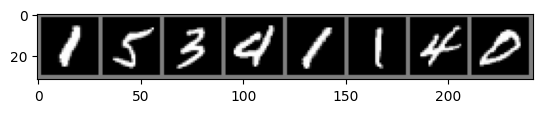

1     5     3     4     1     1     4     0    


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3,padding= 1)
        # self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(64, 128, 3,padding= 1)
        self.conv3 = nn.Conv2d(128, 128, 3,padding= 1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding= 1)
        self.conv5 = nn.Conv2d(128, 256, 3,padding= 1)
        self.conv6 = nn.Conv2d(256,512, 3, padding=1)
        self.conv7 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, 3,padding= 1)
        self.fc1 = nn.Linear(512, 10)
        self.temp = nn.Conv2d(128, 512, 3, padding= 1)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        y = x
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.bn2(self.conv4(x)))
        z= self.temp(x)
        x = F.relu(self.bn3(self.conv5(x + y)))  # Add y before pooling
        x = F.relu(self.bn4(self.conv6(x)))
        y = x
        x = F.relu(self.bn4(self.conv7(x + z)))  # Add z before convolution
        x = F.relu(self.bn4(self.conv8(x)))
        x = F.adaptive_avg_pool2d(x + y, (1, 1))  # Add y before pooling
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x
net = Net().to(device)

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [9]:
def validator(testloader=None,net=None):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            # perform max along dimension 1, since dimension 0 is batch dimension
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')
    return correct/total

In [10]:
start_epoch=0
end_epoch=10

In [11]:
best_accuracy = -1.0
for epoch in range(start_epoch,end_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate( trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    current_accuracy = validator(testloader=testloader,net=net)
    if current_accuracy>best_accuracy:
        best_accuracy = current_accuracy

        torch.save(
            {'epoch':epoch,
             'model_state_dict': net.state_dict(),
             'optimizer_state_dict': optimizer.state_dict()
             },

             your_google_drive_path+'best_model.pth')
    #Save model as checkpoint
    torch.save(
        {'epoch':epoch,
         'model_state_dict': net.state_dict(),
         'optimizer_state_dict': optimizer.state_dict()
         },
         your_google_drive_path+'checkpoint.pth')
print('Finished Training')

[1,  2000] loss: 1.837
[1,  4000] loss: 1.657
[1,  6000] loss: 1.600
Accuracy of the network on the 10000 test images: 88 %
[2,  2000] loss: 1.585
[2,  4000] loss: 1.584
[2,  6000] loss: 1.583
Accuracy of the network on the 10000 test images: 88 %
[3,  2000] loss: 1.578
[3,  4000] loss: 1.580
[3,  6000] loss: 1.579
Accuracy of the network on the 10000 test images: 88 %
[4,  2000] loss: 1.560
[4,  4000] loss: 1.484
[4,  6000] loss: 1.481
Accuracy of the network on the 10000 test images: 98 %
[5,  2000] loss: 1.476
[5,  4000] loss: 1.476
[5,  6000] loss: 1.475
Accuracy of the network on the 10000 test images: 99 %
[6,  2000] loss: 1.474
[6,  4000] loss: 1.474
[6,  6000] loss: 1.474
Accuracy of the network on the 10000 test images: 99 %
[7,  2000] loss: 1.474
[7,  4000] loss: 1.472
[7,  6000] loss: 1.472
Accuracy of the network on the 10000 test images: 99 %
[8,  2000] loss: 1.471
[8,  4000] loss: 1.472
[8,  6000] loss: 1.473
Accuracy of the network on the 10000 test images: 99 %
[9,  200

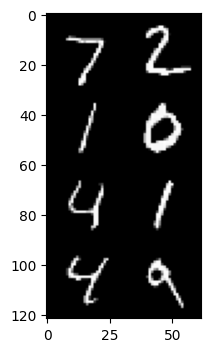

GroundTruth:  7     2     1     0     4     1     4     9    


In [12]:
dataiter = iter(testloader)
images, labels = next(dataiter)
plt.subplots(figsize=(2,4))
# print images
plt.imshow(torchvision.utils.make_grid(images[:8],nrow=2).permute(1,2,0))
plt.show()
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [13]:
net_best = Net().to(device)
checkpoint = torch.load(your_google_drive_path+'best_model.pth')
net_best.load_state_dict(checkpoint['model_state_dict'])


images = images.to(device)
labels = labels.to(device)

outputs = net_best(images)

In [14]:
_, predicted = torch.max(outputs, 1)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))
print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(8)))


GroundTruth:  7     2     1     0     4     1     4     9    
Predicted:    7     2     1     0     4     1     4     9    


In [15]:
from PIL import Image
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.classes = os.listdir(data_folder)
        self.data = self._load_data()

    def _load_data(self):
        data = []
        for i, class_folder in enumerate(self.classes):
            class_path = os.path.join(self.data_folder, class_folder)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                data.append((img_path, i))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        return img, label

In [16]:
transform_1 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])
data=CustomDataset(data_folder="/content/drive/MyDrive/HINDI/numerals/",transform=transform_1)

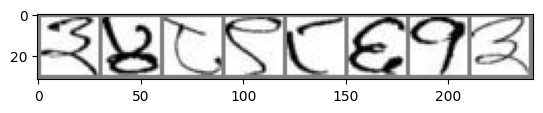

3     4     8     9     8     6     1     3    


In [17]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
batch_size=8
# Randomly split the dataset into train and test sets
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
trainloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
classes = data.classes
dataiter = iter(trainloader)
images, labels = next(dataiter) #4 images will be there since batch size is 4, images have [batch,channel,heigh,width]
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [18]:
start_epoch=0
end_epoch=10

In [19]:
del inputs,images,labels,loss,optimizer

In [20]:
net1=Net().to(device)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)

In [22]:
best_accuracy = -1.0
for epoch in range(start_epoch,end_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate( trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    current_accuracy = validator(testloader=testloader,net=net1)
    if current_accuracy>best_accuracy:
        best_accuracy = current_accuracy

        torch.save(
            {'epoch':epoch,
             'model_state_dict': net1.state_dict(),
             'optimizer_state_dict': optimizer.state_dict()
             },

             your_google_drive_path+'hindi_best_model.pth')

    #Save model as checkpoint
    torch.save(
        {'epoch':epoch,
         'model_state_dict': net1.state_dict(),
         'optimizer_state_dict': optimizer.state_dict()
         },
         your_google_drive_path+'hindi_checkpoint.pth')
print('Finished Training')

Accuracy of the network on the 334 test images: 14 %
Accuracy of the network on the 334 test images: 22 %
Accuracy of the network on the 334 test images: 27 %
Accuracy of the network on the 334 test images: 39 %
Accuracy of the network on the 334 test images: 40 %
Accuracy of the network on the 334 test images: 46 %
Accuracy of the network on the 334 test images: 51 %
Accuracy of the network on the 334 test images: 51 %
Accuracy of the network on the 334 test images: 53 %
Accuracy of the network on the 334 test images: 64 %
Finished Training


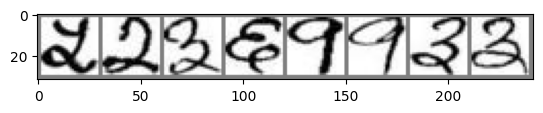

Predicted:    2     7     8     9     5     8     5     0    


In [23]:
dataiter = iter(testloader)
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images))
print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(8)))

In [24]:
net_best = Net().to(device)
checkpoint = torch.load(your_google_drive_path+'hindi_best_model.pth')
net_best.load_state_dict(checkpoint['model_state_dict'])


images = images.to(device)
labels = labels.to(device)

outputs = net_best(images)

In [25]:
_, predicted = torch.max(outputs, 1)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))
print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(8)))

GroundTruth:  5     2     3     6     1     1     3     3    
Predicted:    0     0     3     6     1     1     3     3    


In [26]:
net2=Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)
checkpoint = torch.load(your_google_drive_path+'best_model.pth')
start_epoch = checkpoint['epoch']+1
net2.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [27]:
for param in net2.parameters():
    param.requires_grad = False
# Unfreeze the last few layers
for param in net2.fc1.parameters():
    param.requires_grad = True

In [28]:
optimizer = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)

In [29]:
del loss

In [30]:
start_epoch=0
best_accuracy = -1.0
for epoch in range(start_epoch,end_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate( trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    current_accuracy = validator(testloader=testloader,net=net2)
    if current_accuracy>best_accuracy:
        best_accuracy = current_accuracy

        torch.save(
            {'epoch':epoch,
             'model_state_dict': net2.state_dict(),
             'optimizer_state_dict': optimizer.state_dict()
             },

             your_google_drive_path+'hindi_ft_best_model.pth')

    #Save model as checkpoint
    torch.save(
        {'epoch':epoch,
         'model_state_dict': net2.state_dict(),
         'optimizer_state_dict': optimizer.state_dict()
         },
         your_google_drive_path+'hindi_finetuned_checkpoint.pth')
print('Finished Training')

Accuracy of the network on the 334 test images: 11 %
Accuracy of the network on the 334 test images: 16 %
Accuracy of the network on the 334 test images: 20 %
Accuracy of the network on the 334 test images: 20 %
Accuracy of the network on the 334 test images: 17 %
Accuracy of the network on the 334 test images: 21 %
Accuracy of the network on the 334 test images: 19 %
Accuracy of the network on the 334 test images: 17 %
Accuracy of the network on the 334 test images: 19 %
Accuracy of the network on the 334 test images: 18 %
Finished Training


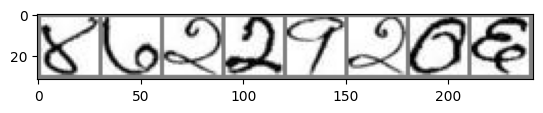

GroundTruth:  4     7     2     2    


In [31]:
dataiter = iter(testloader)
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [32]:
net_best = Net().to(device)
checkpoint = torch.load(your_google_drive_path+'hindi_ft_best_model.pth')
net_best.load_state_dict(checkpoint['model_state_dict'])


images = images.to(device)
labels = labels.to(device)

outputs = net_best(images)

In [33]:
_, predicted = torch.max(outputs, 1)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

GroundTruth:  4     7     2     2    
Predicted:  0     5     7     3    
